In [4]:
%matplotlib inline
from __future__ import division

%load_ext autoreload
%autoreload
import numpy as np
from KBO import *
from linktools import *
import csv
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import KDTree
import networkx as nx

In [5]:
target='S1'
truth_in = 'fakes_40_50_AU_S1.csv'
fakes_det_in = 'noise_catalogs_40_50AU/cat_noise_4090.csv'   # typical catalog with noise
do_noise = True     # include noise points in analysis
astrometric_err = 0.2   # estimated astrometric error in arcseconds
fakes_truth = pd.read_csv(truth_in) 
fakes_det = pd.read_csv(fakes_det_in)
para = exposure_parallax()        # get dlon, dlat, vlon, vlat for each exposure

In [6]:
# Create the input catalog
def ingest_catalog(fake_det_in):
    fake_cat = Catalog(rows=fakes_det_in,fakeid=int,date=float,expnum=int,exptime=float, 
                       ra=float,dec=float,band=str,ccd=int,nite=int,objid=int)
    fake_cat.refactor('date', lambda date: ephem.date(date))
    fake_cat.refactor('ra',  lambda ra: hours(ra))
    fake_cat.refactor('dec', lambda dec: degrees(dec))
    return fake_cat
fake_cat = ingest_catalog(fakes_det_in)

In [7]:
def denoise(catalog):
    return Catalog(p for p in catalog._points if p.fakeid>0)

In [11]:
def make_kdtree(catalog):
    '''
    Makes a KDtree from the ra, dec points in catalog.
    '''
    x = np.array([[point.ra for point in catalog], 
                  [point.dec for point in catalog]]).transpose()
    return KDTree(x)

In [12]:
def trees_points_by_nite(catalog):
    '''
    Returns dictionares of points and KDtrees for each nite in the catalog.
    '''
    cats_by_nite = catalog.groupby('nite')
    nites = sorted(cats_by_nite.keys())
    trees = {}
    points = {}
    for nite in nites:
        trees[nite]=make_kdtree(cats_by_nite[nite])
        points[nite] = [p for p in cats_by_nite[nite]]
    return trees, points
            

In [13]:
class ObjectLinker(object):
    def __init__(self, target, objcat, band = None, exclude_snobjids=None, date_start=None, look_ahead_visits=2):

# objcat is a Catalog (for now) which must contain at least the following columns:
#     date (as a DateTime object)
#     nite
#     ra, dec in radians or ephem.Angle objects
#     band
#     expnum
#     exptime (in seconds)
#     objid (a unique identifier, such as snobjid)
#     mag
#     ccd
        self.objects = objcat
        if band is not None: self.objects = Catalog(obj for obj in self.objects if obj.band == band)
        if exclude_snobjids is not None: self.objects = Catalog(obj for obj in self.objects if obj.objid not in exclude_snobjids)
#
        if date_start is not None: self.objects = Catalog(obj for obj in self.objects if obj.date>=date_start)
        self.objects.add_constant('obscode', 807)
        self.objects.add_constant('err', astrometric_err)
        self.objects.orderby('date')
        self.field = fields[target]
        self.band = band
        self.look_ahead_visits = look_ahead_visits   # how many visits to look ahead for linking
        self.vmax = 150    # arcsec/day
        self.nominal_distance = 40  # AU
#        self.trees_by_nite, self.points_by_nite = trees_points_by_nite(objcat)
        
    def points_near(self, center, r, nite):
        x = [center.ra, center.dec]
        near_ids = self.trees_by_nite[nite].query_ball_point(x, r)
        near_points = [self.points_by_nite[nite][i] for i in near_ids]
        return near_points
        
    
    def cosine_cut(self, displacement):
        '''
        The requirement on directional alignment between two points and that expected from earth reflex motion.
        It's more generous for lower values of the displacement (in arcseconds).
        '''
        if displacement<400:
            return 0.7
        elif 400<displacement<=800:
            return 0.7 + (0.95-0.7)/(800-400)*(displacement-400)
        else:
            return 0.95
    
    def tno_like(self, point1, point2, lon1, lat1, dlon, dlat):
        '''
        returns True if point1 and point2 are in a TNO-like relationship to each other, i.e. displacement
        magnitude and direction consistent with earth reflex motion. 
        point1 = point in earlier visit
        point2 = point in subsequent visit that we are trying to link to point1.
        lon1, lat1 = ecliptic coords of point1
        dlon, dlat = expected change in direction from one visit to next: dlon = nextvisit.dlon - thisvisit.dlon, etc.
        '''
        lon2, lat2 = Ecliptic(Equatorial(point2.ra, point2.dec)).get()
        displacement = ephem.separation((lon2, lat2), (lon1, lat1))
#        norm = np.sqrt(np.cos(self.centerlat)**2*dlon**2 + dlat**2)
#        dot = np.cos(self.centerlat)**2*(lon2 - lon1)*dlon + (lat2 - lat1)*dlat
        norm = np.sqrt(np.cos(lat1)**2*dlon**2 + dlat**2)
        dot = np.cos(lat1)**2*(lon2 - lon1)*dlon + (lat2 - lat1)*dlat
        if point2.date != point1.date:
            velocity = displacement/(point2.date - point1.date)
        else: 
            velocity=9999
        cosine = dot/(norm*displacement)
        # The old way:
#        return True if cosine > np.cos(20*np.pi/180) and velocity < self.vmax*np.pi/(180*3600) else False 
#       The new way accounts for the noise in cosine for smaller values of displacement.
        displacement_asec = displacement*180/np.pi*3600
        return True if velocity<self.vmax and cosine>self.cosine_cut(displacement_asec) else False
       
    def link_obj(self, point):
        visits = self.field.visits
        visits.orderby('nite')
        thisvisit = visits[point.nite]
        this_dlon, this_dlat = para[point.expnum]['dlon'], para[point.expnum]['dlat']
        this_vlon, this_vlat = para[point.expnum]['vlon'], para[point.expnum]['vlat']
        nextvisit = thisvisit
        next_obj = []
        for i in range(self.look_ahead_visits):
            
            # get the next visit
            try:
                nextvisit = next(visit for visit in visits if visit.nite > nextvisit.nite)
            except StopIteration: pass
            if nextvisit is None: 
                print "nextvisit is None!"
                return []
        
            days_between_visits = ephem.date(pretty_nite(nextvisit.nite))-ephem.date(pretty_nite(thisvisit.nite))
            if days_between_visits>0:
                deltalon, deltalat = this_vlon/self.nominal_distance*days_between_visits*np.pi/180, this_vlat/self.nominal_distance*days_between_visits*np.pi/180
                lon, lat = Ecliptic(Equatorial(point.ra, point.dec)).get()
                search_center = Equatorial(Ecliptic(lon+deltalon, lat+deltalat))
#                print ephem.separation((search_center.ra, search_center.dec), (point.ra, point.dec))*3600*180/np.pi/days_between_visits
                sep_max = self.vmax*np.pi/(180*3600)*(days_between_visits)/2
                current_objects = [obj for obj in self.objects if obj.nite == nextvisit.nite \
                                   and (self.band is None or obj.band == self.band) \
                                    and ephem.separation((search_center.ra, search_center.dec), (obj.ra, obj.dec))<sep_max]
# This method uses KDtrees. Our current implementation is slower than the list-comprehension method above.        
#                current_objects = self.points_near(search_center, sep_max, nextvisit.nite)
                # now the real work: for each object, test to see
                # if it's consistent with being the next point in
                # a KBO trajectory.
                dlon, dlat = nextvisit.dlon - thisvisit.dlon, nextvisit.dlat - thisvisit.dlat
                for point2 in current_objects:
                    next_dlon, next_dlat = para[point2.expnum]['dlon'], para[point2.expnum]['dlat']
                    dlon, dlat = next_dlon-this_dlon, next_dlat-this_dlat
                    if self.tno_like(point, point2, lon, lat, dlon, dlat): next_obj.append(point2)
        return next_obj

In [14]:
def do_link(linker):
    good_triplets = []
    cat1 = linker.objects
    current_nite = 0
    for obj1 in cat1:
        if obj1.nite>current_nite:
#            print 'Linking points from nite: ', obj1.nite
            current_nite = obj1.nite
        next_points = linker.link_obj(obj1)
        for obj2 in next_points:
#            print '.',
            next_next_points = linker.link_obj(obj2)
            for obj3 in next_next_points:
                triple=Catalog([obj1, obj2, obj3])
                ra = [obj1.ra, obj2.ra, obj3.ra]
                dec=[obj1.dec, obj2.dec, obj3.dec]
                dates = [exposure_midpoint(obj1, fields[target]), exposure_midpoint(obj2, fields[target]), 
                         exposure_midpoint(obj3, fields[target])]
                orbit = Orbit(triple)
                if orbit.chisq<2 and orbit.ndof==1 and orbit.elements['a']>20:    # good triplet
                    good_triplets.append(triple)
    return good_triplets

In [15]:
def process_catalog(fake_cat):
    linker = ObjectLinker(target, fake_cat, look_ahead_visits=2)
    good_triplets = do_link(linker)
    return good_triplets

In [16]:
def subgraphs(triplets):
    G = nx.Graph()
    for triplet in triplets:
        observations = sorted([obs.objid for obs in triplet])
        G.add_nodes_from(observations)
        G.add_edge(observations[0], observations[1])
        G.add_edge(observations[1], observations[2])
    return [s for s in nx.connected_component_subgraphs(G)]

In [22]:
def connected_observations(catalog, subgraph):
    objids = [node for node in nx.nodes_iter(subgraph)]
    points = [p for p in catalog if p.objid in objids]
    cat = Catalog(points)
    cat.add_constant('obscode', 807)
    cat.add_constant('err', astrometric_err)
    return cat

def isSignal(cat):
    return np.all([obs.fakeid>0 for obs in cat])

In [23]:
from os import listdir
from os.path import isfile, join
path = 'noise_catalogs_40_50AU'
catfiles = [f for f in listdir(path) if isfile(join(path,f))]

In [24]:
Ntot = 0
Nfound = 0
for cat_in in catfiles:
    fake_cat = ingest_catalog(join(path,cat_in))
    Ntot +=1
    print 'Processing catalog ', cat_in
    good_triplets = process_catalog(denoise(fake_cat))
#    print 'Good triplets found: ', len(good_triplets)
    subs = subgraphs(good_triplets)
#    print 'Connected subgraphs found: ', len(subs)
    orbits = []
    big_subs=[]
    for sub in subs:
        if len(sub)>=3:
            big_subs.append(sub)
            observations = connected_observations(fake_cat, sub)
            if isSignal(observations):
#                orbit = Orbit(observations)
#                orbits.append(orbit)
#                print orbit.chisq, orbit.ndof, orbit.elements, orbit.elements_errs
                Nfound +=1
print 'Found ', Nfound, ' of ', Ntot, ' detectable fakes'
        

Processing catalog  cat_noise_1012722.csv
Processing catalog  cat_noise_1021621.csv
Processing catalog  cat_noise_1023974.csv
Processing catalog  cat_noise_1024918.csv
Processing catalog  cat_noise_1029134.csv
Processing catalog  cat_noise_1036328.csv
Processing catalog  cat_noise_1038999.csv
Processing catalog  cat_noise_1039973.csv
Processing catalog  cat_noise_1046343.csv
Processing catalog  cat_noise_1048637.csv
Processing catalog  cat_noise_1052059.csv
Processing catalog  cat_noise_1055534.csv
Processing catalog  cat_noise_1060528.csv
Processing catalog  cat_noise_10637.csv
Processing catalog  cat_noise_1070406.csv
Processing catalog  cat_noise_1070673.csv
Processing catalog  cat_noise_1077459.csv
Processing catalog  cat_noise_1089166.csv
Processing catalog  cat_noise_1095726.csv
Processing catalog  cat_noise_110191.csv
Processing catalog  cat_noise_1102207.csv
Processing catalog  cat_noise_1115469.csv
Processing catalog  cat_noise_1120268.csv
Processing catalog  cat_noise_1132859

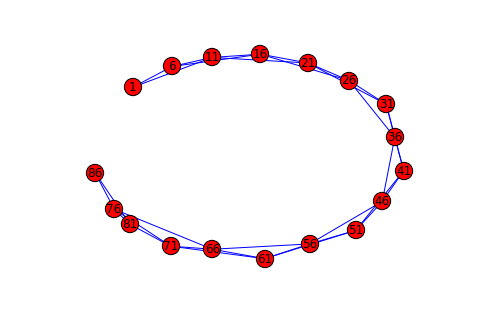

In [25]:
nx.draw(big_subs[0], with_labels=True, node_size=300, edge_color='b')

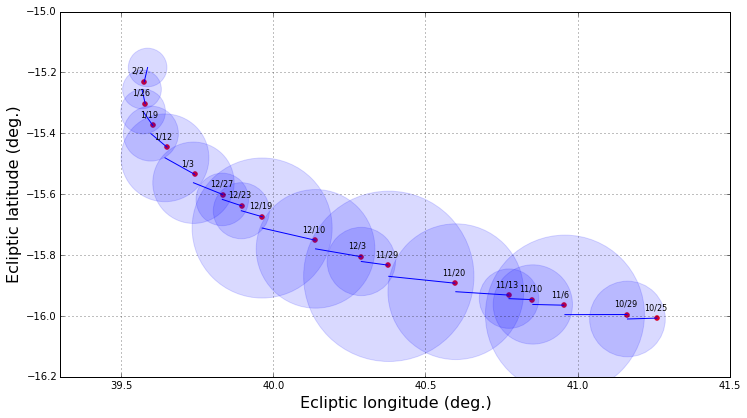

In [61]:
r2d = 180/np.pi
cat_clean = denoise(fake_cat)
fig = plt.figure(2, figsize=(12,12))
ax = fig.add_subplot(1,1,1)
for i in range(len(cat_clean._points)-1):
    point = cat_clean._points[i]
    next_point = cat_clean._points[i+1]
    lon, lat = Ecliptic(Equatorial(point.ra, point.dec)).get()
    date = str(ephem.date(point.date)).split()[0][5:]
    lon2, lat2 = Ecliptic(Equatorial(next_point.ra, next_point.dec)).get()
    dlon, dlat = para[next_point.expnum]['dlon']-para[point.expnum]['dlon'], para[next_point.expnum]['dlat']-para[point.expnum]['dlat']
    vlon, vlat = para[point.expnum]['vlon'], para[point.expnum]['vlat']
#    plt.arrow(lon, lat, dlon/40, dlat/40, lw=1, ls='dashed', head_width=0.0005, head_length=0.0005, 
#              fc='b', ec='k', alpha=0.5)
    ax.plot([lon*r2d, (lon+dlon/40)*r2d], [lat*r2d, r2d*(lat+dlat/40)], lw=1, color='b')
    ax.text(lon*r2d-0.04, lat*r2d+0.03, date, fontsize=8, color='k')
    ax.scatter(lon*r2d, lat*r2d, s=20, color='r')
    ax.set_aspect('equal')
    ax.grid()
    r = np.sqrt(dlon**2*np.cos(lat)**2 + dlat**2)/30
    circle = plt.Circle((r2d*(lon+dlon/40), r2d*(lat+dlat/40)), r*r2d , color='b', alpha=0.15)
    fig.gca().add_artist(circle)
    ax.set_xlabel('Ecliptic longitude (deg.)', fontsize=16)
    ax.set_ylabel('Ecliptic latitude (deg.)', fontsize=16)
    ax.set_xlim([39.3, 41.5])
    ax.set_ylim([-16.2, -15.0])
    plt.savefig('linkplot_'+str(i)+'.png')
    plt.savefig('linkplot_'+str(i)+'.pdf')

#orbit = Orbit(observations)
#print orbit.elements, orbit.elements_errs

In [27]:
orbit = Orbit(observations)
print orbit.elements, orbit.elements_errs

{'a': 41.99660639302517, 'lan': 40.30274298978722, 'e': 0.03585227857979982, 'i': 92.56538904245534, 'top': 2467670.6768569443, 'aop': 27.250375533900208} {'a': 0.030115385958951166, 'lan': 0.010043888129248887, 'e': 0.010673854141295017, 'i': 0.035907128045337411, 'top': 4852.0353442308442, 'aop': 19.37905238807404}
